# setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from collections import Counter

# x

In [2]:
file_path = '/home/remote/Documents/datasets/lesaude/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/record_list.csv'

In [ ]:
df = pd.read_csv(file_path)

In [4]:
patient_stats = df.groupby('subject_id')['study_id'].nunique().sort_values(ascending=False) # number of ecgs per patient
patient_stats

subject_id
11296936    260
13475033    247
12298456    225
11818101    217
11372027    202
           ... 
19999303      1
19999204      1
19998843      1
10001176      1
10001122      1
Name: study_id, Length: 161352, dtype: int64

In [5]:
total_patients = len(patient_stats)
total_ecgs = len(df)
mean_ecgs = patient_stats.mean()
median_ecgs = patient_stats.median()
max_ecgs = patient_stats.max()
total_patients, total_ecgs, mean_ecgs, median_ecgs, max_ecgs

(161352, 800035, np.float64(4.958320938073281), np.float64(2.0), np.int64(260))

In [6]:
singletons = patient_stats[patient_stats == 1].count()
singletons

np.int64(57344)

In [7]:
doubles = patient_stats[patient_stats == 2].count()
doubles

np.int64(29218)

In [8]:
multi_sample_patients = patient_stats[patient_stats > 1].count()
multi_sample_patients

np.int64(104008)

In [9]:
usable_counts = patient_stats[patient_stats > 1]
total_sequential_pairs = (usable_counts - 1).sum() # we have n-1 sequential pairs
total_combinations = (usable_counts * (usable_counts - 1)) // 2
total_sequential_pairs, total_combinations.sum()

(np.int64(638683), np.int64(6844205))

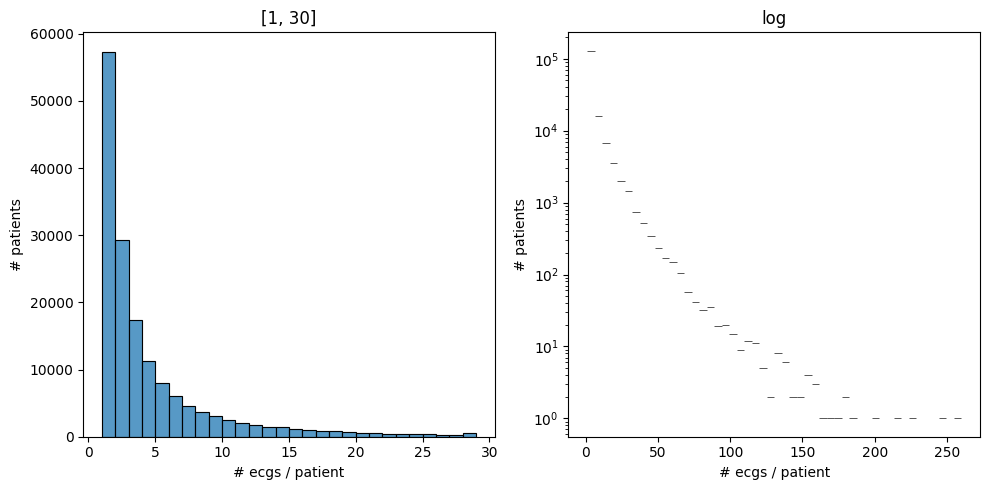

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(patient_stats, bins=range(1, 30), kde=False)
plt.title('[1, 30]')
plt.xlabel('# ecgs / patient')
plt.ylabel('# patients')

plt.subplot(1, 2, 2)
sns.histplot(patient_stats, bins=50, log_scale=(False, True))
plt.title('log')
plt.xlabel('# ecgs / patient')
plt.ylabel('# patients')

plt.tight_layout()
plt.show()

# y

## raw

In [11]:
def parse_label_column(val):
    """Parses the stringified list format in the CSV."""
    if pd.isna(val) or val == '':
        return []
    try:
        # Converts "['A', 'B']" to list ['A', 'B']
        return ast.literal_eval(val)
    except:
        return []

In [12]:
file_path = '/home/remote/Documents/datasets/lesaude/mimic-iv-ecg-ext-icd-diagnostic-labels-for-mimic-iv-ecg-1.0.1/records_w_diag_icd10.csv'

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df['ecg_time'] = pd.to_datetime(df['ecg_time'])

In [ ]:
TARGET_COL = 'all_diag_all' # maybe hosp_diag_hosp later
df['parsed_labels'] = df[TARGET_COL].apply(parse_label_column)

In [16]:
all_codes = [code for sublist in df['parsed_labels'] for code in sublist]
code_counts = Counter(all_codes)
print("\nTop 20 Most Common ICD Codes:")
for code, count in code_counts.most_common(20):
    print(f"  {code}: {count:,} occurrences")


Top 20 Most Common ICD Codes:
  I10: 181,341 occurrences
  E785: 151,925 occurrences
  I2510: 127,182 occurrences
  I4891: 97,042 occurrences
  K219: 93,579 occurrences
  Z87891: 90,112 occurrences
  N179: 85,043 occurrences
  E119: 75,297 occurrences
  I509: 74,789 occurrences
  F329: 65,305 occurrences
  Z7901: 60,319 occurrences
  E039: 52,557 occurrences
  I129: 52,298 occurrences
  Z794: 51,488 occurrences
  D649: 49,479 occurrences
  F419: 48,683 occurrences
  N390: 48,182 occurrences
  J449: 41,612 occurrences
  I252: 40,791 occurrences
  N189: 40,699 occurrences


In [17]:
print(f"Total ECGs with Labels: {len(df[df['parsed_labels'].map(len) > 0]):,}")
print(f"Total Unique ICD Codes: {len(code_counts):,}")
print(f"Avg Codes per ECG:      {pd.Series([len(x) for x in df['parsed_labels']]).mean():.2f}")

Total ECGs with Labels: 468,005
Total Unique ICD Codes: 15,197
Avg Codes per ECG:      8.15


In [18]:
df = df.sort_values(by=['subject_id', 'ecg_time'])
# t -> t+1
df['next_subject'] = df['subject_id'].shift(-1)
df['next_labels'] = df['parsed_labels'].shift(-1)

In [19]:
def is_different(row):
    set_curr = set(row['parsed_labels'])
    set_next = set(row['next_labels'])
    return set_curr != set_next

def calc_jaccard(row):
    set_curr = set(row['parsed_labels'])
    set_next = set(row['next_labels'])
    intersection = len(set_curr.intersection(set_next))
    union = len(set_curr.union(set_next))
    if union == 0: return 1.0 # Both empty
    return intersection / union

In [20]:
valid_pairs = df[df['subject_id'] == df['next_subject']].copy()

valid_pairs['has_change'] = valid_pairs.apply(is_different, axis=1)
valid_pairs['jaccard'] = valid_pairs.apply(calc_jaccard, axis=1)

In [21]:
total_pairs = len(valid_pairs)
changed_pairs = valid_pairs['has_change'].sum()
stable_pairs = total_pairs - changed_pairs

print(f"Total Sequential Pairs: {total_pairs:,}")
print(f"Stable Pairs (Identity): {stable_pairs:,} ({stable_pairs/total_pairs:.1%})")
print(f"Changed Pairs (Action):  {changed_pairs:,} ({changed_pairs/total_pairs:.1%})")

Total Sequential Pairs: 638,683
Stable Pairs (Identity): 408,009 (63.9%)
Changed Pairs (Action):  230,674 (36.1%)


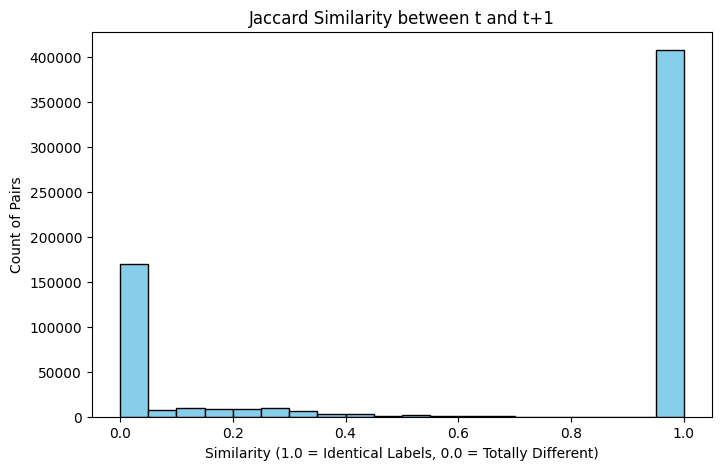

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(valid_pairs['jaccard'], bins=20, color='skyblue', edgecolor='black')
# plt.xlabel('jaccard sim')
# plt.ylabel('# pairs')
plt.title('Jaccard Similarity between t and t+1')
plt.xlabel('Similarity (1.0 = Identical Labels, 0.0 = Totally Different)')
plt.ylabel('Count of Pairs')
plt.show()

In [23]:
len(valid_pairs[valid_pairs['jaccard'] == 0]), len(valid_pairs[valid_pairs['jaccard'] < 0.5])

(167429, 227104)

## chapter ix (and two digits)

In [24]:
def filter_and_cluster_cardiac(codes):
    """
    1. Filter for ICD codes starting with 'I' (Circulatory).
    2. Truncate to 3 digits (Group I48.9.1 and I48.1 into 'I48').
    """
    cardiac_clusters = set()
    for code in codes:
        if code.startswith('I'):
            # cluster = code[:]
            # Truncate to first 3 chars for broader disease categories
            cluster = code[:3]
            cardiac_clusters.add(cluster)
    return list(cardiac_clusters)

In [ ]:
df = pd.read_csv(file_path)

In [26]:
df['parsed_all'] = df['all_diag_all'].apply(parse_label_column)
df['cardiac_state'] = df['parsed_all'].apply(filter_and_cluster_cardiac)

In [27]:
all_clusters = [c for sublist in df['cardiac_state'] for c in sublist]
cluster_counts = Counter(all_clusters)

In [28]:
print(f"New Unique Cardiac Clusters: {len(cluster_counts)}")
print("\nTop 15 Cardiac Clusters (The 'Actions'):")
for code, count in cluster_counts.most_common(15):
    description = "Unknown"
    # Rough manual mapping for context
    if code == 'I10': description = "Hypertension"
    if code == 'I25': description = "Ischemic Heart Disease (CAD)"
    if code == 'I48': description = "Atrial Fibrillation/Flutter"
    if code == 'I50': description = "Heart Failure"
    if code == 'I51': description = "Ill-defined Heart Disease"
    if code == 'I12': description = "Hypertensive Kidney Disease"
    if code == 'I21': description = "Acute MI (STEMI/NSTEMI)"
    if code == 'I11': description = "Hypertensive Heart Disease"
    if code == 'I34': description = "Mitral Valve Disorders"
    if code == 'I42': description = "Cardiomyopathy"
    print(f"  {code} ({description}): {count:,}")

New Unique Cardiac Clusters: 76

Top 15 Cardiac Clusters (The 'Actions'):
  I10 (Hypertension): 181,341
  I25 (Ischemic Heart Disease (CAD)): 144,756
  I48 (Atrial Fibrillation/Flutter): 123,899
  I50 (Heart Failure): 122,684
  I12 (Hypertensive Kidney Disease): 70,871
  I95 (Unknown): 45,430
  I21 (Acute MI (STEMI/NSTEMI)): 45,119
  I27 (Unknown): 29,018
  I47 (Unknown): 24,981
  I42 (Cardiomyopathy): 21,400
  I35 (Unknown): 19,684
  I34 (Mitral Valve Disorders): 18,717
  I73 (Unknown): 18,386
  I44 (Unknown): 18,058
  I13 (Unknown): 17,919


In [29]:
print(f"Total ECGs with Labels: {len(df[df['cardiac_state'].map(len) > 0]):,}")
print(f"Total Unique ICD Codes: {len(cluster_counts):,}")
print(f"Avg Codes per ECG:      {pd.Series([len(x) for x in df['cardiac_state']]).mean():.2f}")

Total ECGs with Labels: 367,662
Total Unique ICD Codes: 76
Avg Codes per ECG:      1.45


In [30]:
len(df[df['cardiac_state'].map(len) == 0])

432373

In [31]:
df = df.sort_values(by=['subject_id', 'ecg_time'])
# t -> t+1
df['next_subject'] = df['subject_id'].shift(-1)
df['next_labels'] = df['cardiac_state'].shift(-1)

In [32]:
def is_different(row):
    set_curr = set(row['cardiac_state'])
    set_next = set(row['next_labels'])
    return set_curr != set_next

def calc_jaccard(row):
    set_curr = set(row['cardiac_state'])
    set_next = set(row['next_labels'])
    intersection = len(set_curr.intersection(set_next))
    union = len(set_curr.union(set_next))
    if union == 0: return 1.0 # Both empty
    return intersection / union

In [33]:
valid_pairs = df[df['subject_id'] == df['next_subject']].copy()

valid_pairs['has_change'] = valid_pairs.apply(is_different, axis=1)
valid_pairs['jaccard'] = valid_pairs.apply(calc_jaccard, axis=1)

In [34]:
total_pairs = len(valid_pairs)
changed_pairs = valid_pairs['has_change'].sum()
stable_pairs = total_pairs - changed_pairs

print(f"Total Sequential Pairs: {total_pairs:,}")
print(f"Stable Pairs (Identity): {stable_pairs:,} ({stable_pairs/total_pairs:.1%})")
print(f"Changed Pairs (Action):  {changed_pairs:,} ({changed_pairs/total_pairs:.1%})")

Total Sequential Pairs: 638,683
Stable Pairs (Identity): 465,842 (72.9%)
Changed Pairs (Action):  172,841 (27.1%)


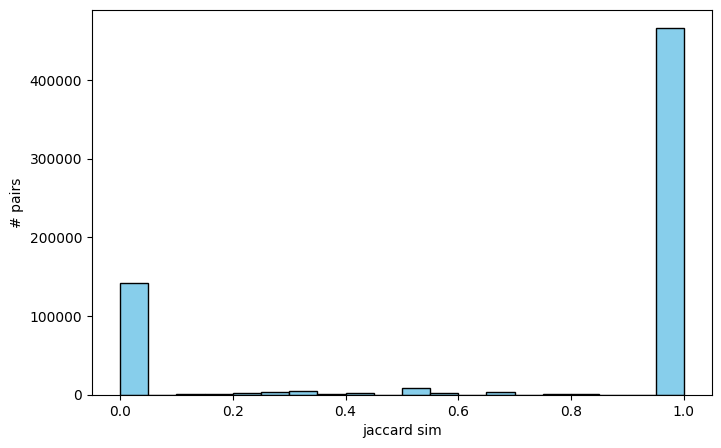

In [35]:
plt.figure(figsize=(8, 5))
plt.hist(valid_pairs['jaccard'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('jaccard sim')
plt.ylabel('# pairs')
# plt.title('Jaccard Similarity between t and t+1')
# plt.xlabel('Similarity (1.0 = Identical Labels, 0.0 = Totally Different)')
# plt.ylabel('Count of Pairs')
plt.show()

### action pairs

In [36]:
def calc_change_magnitude(row):
    set_curr = set(row['cardiac_state'])
    set_next = set(row['next_labels'])
    
    # How many new diseases appeared? (e.g. Normal -> Afib = 1)
    added = len(set_next - set_curr)
    # How many diseases disappeared? (e.g. Ischemia resolved = 1)
    removed = len(set_curr - set_next)
    
    return added, removed, added + removed

In [37]:
changed_df = valid_pairs[valid_pairs['has_change'] == True].copy()

In [38]:
coords = changed_df.apply(calc_change_magnitude, axis=1)
changed_df['added_count'] = coords.apply(lambda x: x[0])
changed_df['removed_count'] = coords.apply(lambda x: x[1])
changed_df['total_magnitude'] = coords.apply(lambda x: x[2])

In [39]:
mag_counts = changed_df['added_count'].value_counts().sort_index()
print("Labels Changed per Step (Added):")
total_changed = len(changed_df)
for magnitude, count in mag_counts.items():
    if magnitude <= 10:  # Print first few
        print(f"  {magnitude} label(s): {count:,} ({count/total_changed:.1%})")
    elif magnitude == 11:
        print(f"  >10 labels: {changed_df[changed_df['added_count'] > 10].shape[0]:,}")
        break

Labels Changed per Step (Added):
  0 label(s): 66,976 (38.8%)
  1 label(s): 41,468 (24.0%)
  2 label(s): 23,838 (13.8%)
  3 label(s): 17,188 (9.9%)
  4 label(s): 11,061 (6.4%)
  5 label(s): 6,377 (3.7%)
  6 label(s): 3,364 (1.9%)
  7 label(s): 1,555 (0.9%)
  8 label(s): 628 (0.4%)
  9 label(s): 244 (0.1%)
  10 label(s): 92 (0.1%)
  >10 labels: 50


In [40]:
mag_counts = changed_df['removed_count'].value_counts().sort_index()
print("Labels Changed per Step (Removed):")
total_changed = len(changed_df)
for magnitude, count in mag_counts.items():
    if magnitude <= 10:  # Print first few
        print(f"  {magnitude} label(s): {count:,} ({count/total_changed:.1%})")
    elif magnitude == 11:
        print(f"  >10 labels: {changed_df[changed_df['removed_count'] > 10].shape[0]:,}")
        break

Labels Changed per Step (Removed):
  0 label(s): 86,971 (50.3%)
  1 label(s): 35,380 (20.5%)
  2 label(s): 19,640 (11.4%)
  3 label(s): 13,254 (7.7%)
  4 label(s): 8,484 (4.9%)
  5 label(s): 4,865 (2.8%)
  6 label(s): 2,433 (1.4%)
  7 label(s): 1,104 (0.6%)
  8 label(s): 424 (0.2%)
  9 label(s): 178 (0.1%)
  10 label(s): 74 (0.0%)
  >10 labels: 34


In [41]:
mag_counts = changed_df['total_magnitude'].value_counts().sort_index()
print("Labels Changed per Step (Added + Removed):")
total_changed = len(changed_df)
for magnitude, count in mag_counts.items():
    if magnitude <= 10:  # Print first few
        print(f"  {magnitude} label(s): {count:,} ({count/total_changed:.1%})")
    elif magnitude == 11:
        print(f"  >10 labels: {changed_df[changed_df['total_magnitude'] > 10].shape[0]:,}")
        break

Labels Changed per Step (Added + Removed):
  1 label(s): 56,271 (32.6%)
  2 label(s): 39,413 (22.8%)
  3 label(s): 31,217 (18.1%)
  4 label(s): 21,315 (12.3%)
  5 label(s): 12,732 (7.4%)
  6 label(s): 6,643 (3.8%)
  7 label(s): 3,110 (1.8%)
  8 label(s): 1,297 (0.8%)
  9 label(s): 518 (0.3%)
  10 label(s): 213 (0.1%)
  >10 labels: 112


In [42]:
pair_counts_per_patient = changed_df['subject_id'].value_counts()
print("\n" + "-" * 40)
print("PATIENT CONTRIBUTION TO DYNAMICS")
print("-" * 40)
print(f"Total Patients contributing to changes: {len(pair_counts_per_patient):,}")
print(f"Max pairs from single patient: {pair_counts_per_patient.max()}")
print(f"Mean pairs per patient: {pair_counts_per_patient.mean():.2f}")


----------------------------------------
PATIENT CONTRIBUTION TO DYNAMICS
----------------------------------------
Total Patients contributing to changes: 55,808
Max pairs from single patient: 100
Mean pairs per patient: 3.10


In [43]:
print("\nPatient Quantiles (How many changed pairs per patient?):")
print(pair_counts_per_patient.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]))


Patient Quantiles (How many changed pairs per patient?):
count    55808.000000
mean         3.097065
std          4.014263
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
90%          7.000000
99%         19.000000
max        100.000000
Name: count, dtype: float64


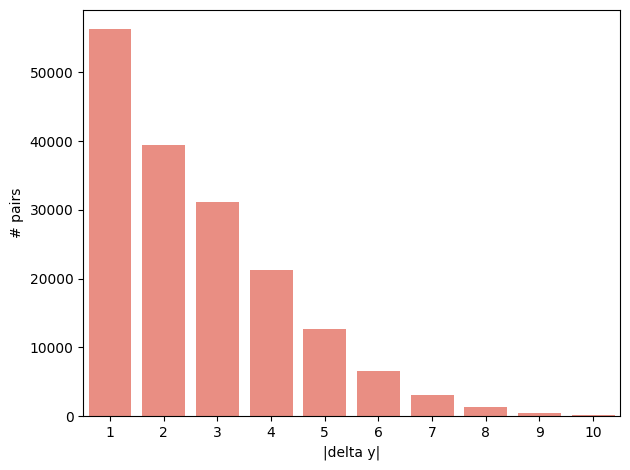

In [44]:
# plt.figure(figsize=(12, 5))

# Plot A: Magnitude of Action (Vector L1 Norm)
# plt.subplot(1, 2, 1)
sns.barplot(x=mag_counts.index[:10], y=mag_counts.values[:10], color='salmon')
# plt.title('actions')
plt.xlabel('|delta y|')
plt.ylabel('# pairs')

# plt.subplot(1, 2, 2)
# # Plot top 100 patients just to show the drop-off
# plt.plot(pair_counts_per_patient.values[:200]) 
# plt.title('Top 200 Patients by "Changed Pair" Count')
# plt.xlabel('Patient Rank')
# plt.ylabel('Number of Changed Pairs')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
mag_counts.values[:10]

array([56271, 39413, 31217, 21315, 12732,  6643,  3110,  1297,   518,
         213])

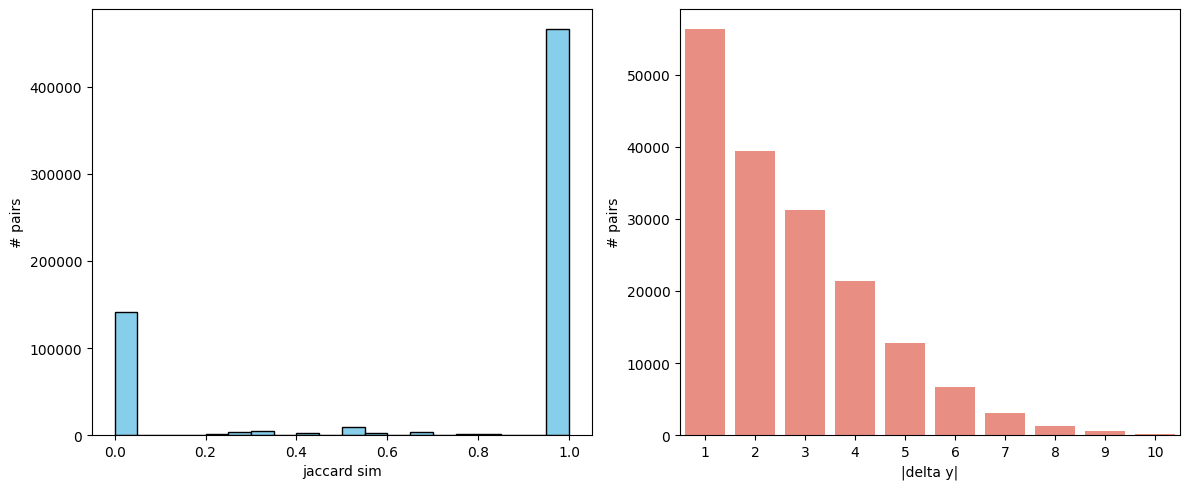

In [48]:
plt.figure(figsize=(12, 5))

# Plot A: Magnitude of Action (Vector L1 Norm)
plt.subplot(1, 2, 1)
plt.hist(valid_pairs['jaccard'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('jaccard sim')
plt.ylabel('# pairs')

plt.subplot(1, 2, 2)


sns.barplot(x=mag_counts.index[:10], y=mag_counts.values[:10], color='salmon')
# plt.title('actions')
plt.xlabel('|delta y|')
plt.ylabel('# pairs')

# # Plot top 100 patients just to show the drop-off
# plt.plot(pair_counts_per_patient.values[:200]) 
# plt.title('Top 200 Patients by "Changed Pair" Count')
# plt.xlabel('Patient Rank')
# plt.ylabel('Number of Changed Pairs')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()